In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

import networkx as nx
from pyvis.network import Network
from node2vec import Node2Vec

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE


import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GATConv           
from torch_geometric.nn import GINConv
from torch_geometric.nn import SAGEConv

/home/hakan/myEnv/532_project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Constants

KEYWORD_SIM_THRESHOLD = 0.3 
AUTHOR_MIN_OVERLAP = 1
NODE2VEC_DIMENSION = 64
NODE2VEC_WALK_LENGTH = 30
NODE2VEC_NUM_OF_WALKS = 40
NODE2VEC_P, NODE2VEC_Q = 0.5, 1.5
SIMILARITY_THRESHOLD = 0.80
CLUSTER_COUNT = 12
DROPOUT = 0.5
LEARNING_RATE = 0.01

In [3]:
# Jaccard similarity helper function

def jaccard_similarity(set1, set2):
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    if not union:
        return 0
    return len(intersection) / len(union)


In [4]:
# Load JSON data

with open('532_data.json', encoding='utf-8') as f:
    papers = json.load(f)

In [5]:
# Create a graph

G = nx.Graph()

In [6]:
# Add nodes for each paper

for paper in papers:
    paper_id = paper["url"].split("/")[-1]
    G.add_node(
        paper_id,
        title=paper.get("title", ""),
        abstract=paper.get("abstract", ""),
        keywords=paper.get("keywords", []),
        authors=paper.get("authors", []),
        type="paper"
    )

In [7]:
# Example of the first node with all attributes
node_id, node_data = list(G.nodes(data=True))[0]

print("Node id")
print(node_id)
print("\n")

print("Title:")
print(node_data["title"])
print("\n")

print("Keywords:")
for kw in node_data["keywords"]:
    print(kw)
print("\n")

print("Authors:")
for author in node_data["authors"]:
    print(author)
print("\n")

print("Abstract:")
print(node_data["abstract"])

Node id
368013


Title:
The Effect of CuttingTool Wear Behaviors on Feed  Rates in Turning of Metal Matrix Composites


Keywords:
Metal MatrixComposites (MMCs)
Machinability
MgO
Tool wear
Built up edge (BUE)


Authors:
Muharrem Pul
Ulvi Şeker


Abstract:
Composite materials, one of them is metal matrix composites (MMCs), is a group of engineering materials whose application fields expand rapidly. In this study, to make an interpretation on machinability of MMCs materials, MMCs materials reinforced Al matrix and MgO which were produced in 5%, 10% and 15% reinforcement-volumeratios (R-V) were subjected to machining tests by carbide (C) and coated carbide (CC) cutting tools. Machining tests were conducted with 300 m/dak cutting speed, at three different feed rates (0.075, 0.15 and 0.225 mm/dev) and fixed depth of cut (1 mm). After the machining tests, wear characteristics were examined by the help of scanning electron microscope (SEM) views of cuttingtools and the findings were discussed.

In [8]:
# Add edges based on shared keywords or shared authors

nodes = list(G.nodes)
for i in range(len(nodes)):
    for j in range(i + 1, len(nodes)):
        node1 = nodes[i]
        node2 = nodes[j]

        # Shared keywords with Jaccard similarity
        keywords1 = set(G.nodes[node1].get('keywords', []))
        keywords2 = set(G.nodes[node2].get('keywords', []))
        keyword_similarity = jaccard_similarity(keywords1, keywords2)

        if keyword_similarity >= KEYWORD_SIM_THRESHOLD:
            if not G.has_edge(node1, node2):
                G.add_edge(node1, node2)

        # Shared authors with count threshold
        authors1 = set(G.nodes[node1].get('authors', []))
        authors2 = set(G.nodes[node2].get('authors', []))
        shared_authors = authors1.intersection(authors2)

        if len(shared_authors) >= AUTHOR_MIN_OVERLAP:
            if not G.has_edge(node1, node2):
                G.add_edge(node1, node2)

In [9]:
len(G.edges)

4096

In [9]:
graph_node_id_list = list(G.nodes())

In [10]:
node2vec = Node2Vec(G, dimensions=NODE2VEC_DIMENSION, walk_length=NODE2VEC_WALK_LENGTH, num_walks=NODE2VEC_NUM_OF_WALKS, workers=8, p=NODE2VEC_P, q=NODE2VEC_Q)
node2vec_model = node2vec.fit(window=15, min_count=1, batch_words=8)
node2vec_embeddings = [node2vec_model.wv[node] for node in graph_node_id_list]

Generating walks (CPU: 8): 100%|██████████| 5/5 [00:00<00:00,  5.94it/s]


In [11]:
def find_similar_nodes(query_vector, node2vec_embeddings, graph_node_id_list, G, top_k=5):
    similarities = []
    
    for idx, node_id in enumerate(graph_node_id_list):
        emb = node2vec_embeddings[idx]
        sim = cosine_similarity([query_vector], [emb])[0][0]
        similarities.append((node_id, sim))
    
    similarities.sort(key=lambda x: x[1], reverse=True)
    top_similar = similarities[:top_k+1]

    print("\nTop Similar Nodes:\n")
    print("Query Node:")
    for node_id, sim in top_similar:
        title = G.nodes[node_id].get("title", "N/A")
        abstract = G.nodes[node_id].get("abstract", "N/A")
        print(f"Node ID: {node_id}")
        print(f"Similarity: {sim:.4f}")
        print(f"Title: {title}")
        print(f"Abstract: {abstract}")
        print("="*30, "\n")

In [12]:
search_node_id = "1327987"
index = graph_node_id_list.index(search_node_id)
query_node_vector = node2vec_embeddings[index]


In [13]:
find_similar_nodes(G=G, query_vector=query_node_vector, node2vec_embeddings=node2vec_embeddings,graph_node_id_list=graph_node_id_list, top_k=5)


Top Similar Nodes:

Query Node:
Node ID: 1327987
Similarity: 1.0000
Title: Study on Data Center Network Topologies for Monitoring Data using Edge/Fog Computing
Abstract: The election of an appropriate data center network topology is key when dealing with surveillance and monitoring processes, such as those devoted to obtaining relevant data for sensor data fusion in any type of remote computing environment so as to perform fault diagnosis and prevention. In this paper, some of the most commonly used topologies to interconnect nodes within a data center bound to edge/fog computing, representing either switch-centric ones or server-centric ones, are reviewed and analyzed from a statistical point of view in order to measure their performance, resulting in server-centric ones doing it better.

Node ID: 810896
Similarity: 0.9997
Title: Arithmetic Study about Energy Save in Switches for some Data Centre Topologies
Abstract: Data Centre facilities are rapidly increasing as parallel computing

In [36]:
connected_nodes = [node for node in G.nodes if G.degree(node) > 0]
isolated_nodes = [node for node in G.nodes if G.degree(node) == 0]

print(len(connected_nodes))
print(len(isolated_nodes))

1330
538


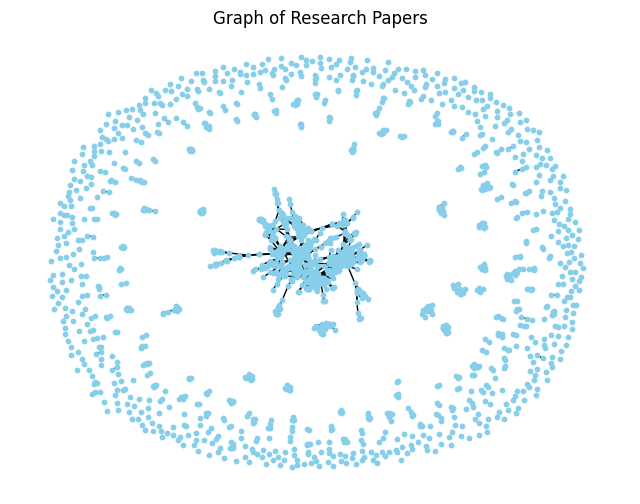

In [16]:
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, node_size=10, node_color='skyblue')
nx.draw_networkx_edges(G, pos, alpha=1)

plt.title("Graph of Research Papers")
plt.axis("off")
plt.show()

In [17]:
inertia = []
k_values = range(6, 24) 

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=532)
    kmeans.fit(node2vec_embeddings)
    inertia.append(kmeans.inertia_)

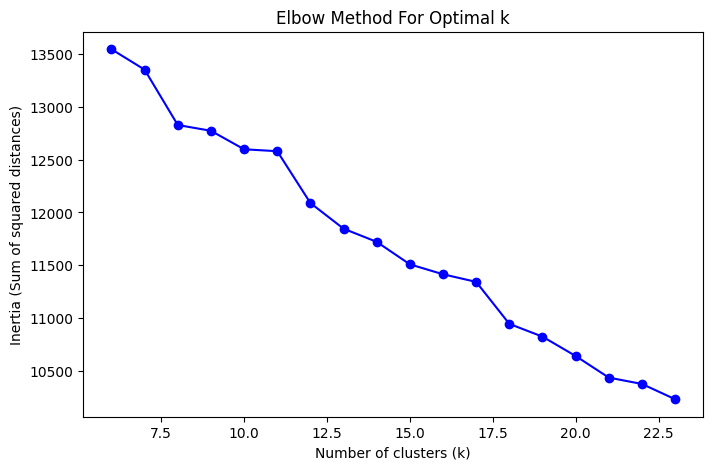

In [18]:
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Sum of squared distances)')
plt.title('Elbow Method For Optimal k')
plt.show()

In [19]:
sil_scores = []
k_values = range(6, 24) 
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=532)
    labels = kmeans.fit_predict(node2vec_embeddings)
    sil_scores.append(silhouette_score(node2vec_embeddings, labels))

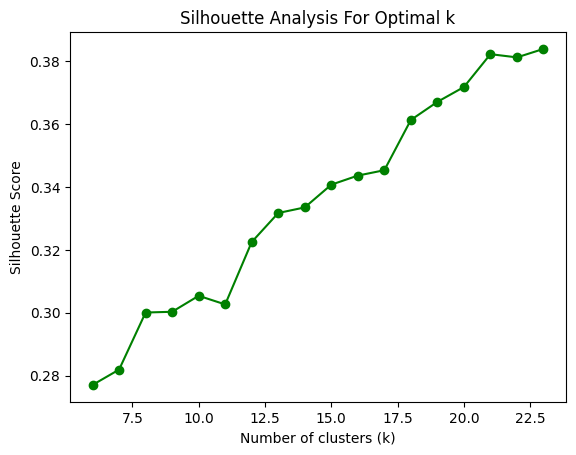


Best number of clusters by silhouette score: k=23 with score=0.3840


In [20]:
plt.plot(range(6, 24), sil_scores, 'go-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis For Optimal k')
plt.show()

best_k = k_values[sil_scores.index(max(sil_scores))]
best_score = max(sil_scores)

print(f"\nBest number of clusters by silhouette score: k={best_k} with score={best_score:.4f}")

In [21]:
kmeans = KMeans(n_clusters=best_k, random_state=532)
cluster_labels = kmeans.fit_predict(node2vec_embeddings)

for node_id, cluster_id in zip(graph_node_id_list, cluster_labels):
    G.nodes[node_id]['cluster'] = cluster_id

/tmp/ipykernel_2058/584797849.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_clusters)


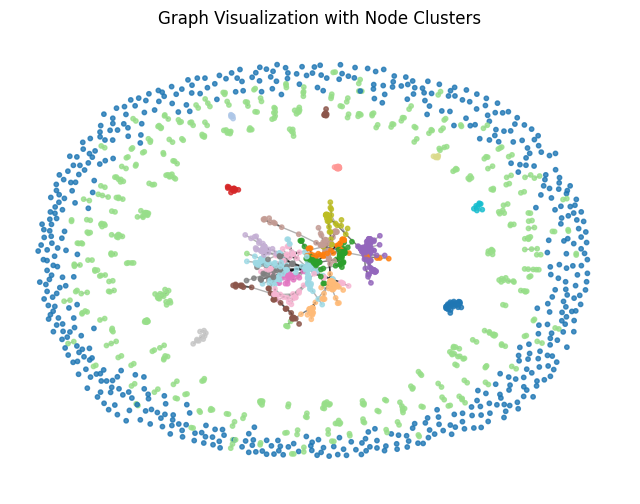

In [37]:
cluster_labels = [G.nodes[n].get('cluster', -1) for n in G.nodes()]
num_clusters = max(cluster_labels) + 1 

cmap = plt.cm.get_cmap('tab20', num_clusters)

node_colors = [cmap(label) if label >= 0 else (0, 0, 0, 0.8) for label in cluster_labels]

plt.figure(figsize=(8, 6))

pos = nx.spring_layout(G, seed=532) 
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=10, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.3)

plt.title("Graph Visualization with Node Clusters")
plt.axis('off')
plt.show()

In [23]:
net = Network(height='750px', width='100%', bgcolor='#222222', font_color='white', notebook=True)

num_clusters = max(cluster_labels) + 1
cmap = plt.cm.get_cmap('tab20', num_clusters)
cluster_labels = [G.nodes[n].get('cluster', -1) for n in G.nodes()]
node_colors = [cmap(label) if label >= 0 else (0, 0, 0, 0.8) for label in cluster_labels]

for i, node in enumerate(G.nodes()):
    cluster_id = cluster_labels[i]
    color = node_colors[i]
    color_hex = '#{:02x}{:02x}{:02x}'.format(
        int(color[0]*255), int(color[1]*255), int(color[2]*255)
    )
    title = G.nodes[node].get("title", "No Title")
    net.add_node(node, label=str(cluster_id), title=title, color=color_hex)

for source, target in G.edges():
    net.add_edge(source, target)

net.show("node2vec.html")


/tmp/ipykernel_2058/2697164130.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_clusters)


node2vec.html


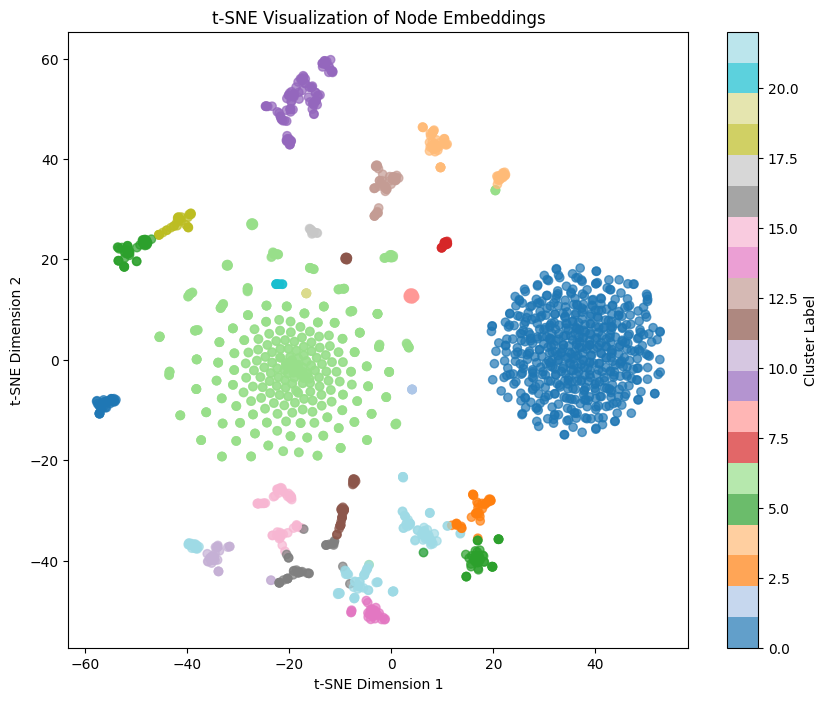

In [24]:
tsne = TSNE(n_components=2, random_state=532)
embeddings_2d = tsne.fit_transform(np.array(node2vec_embeddings))

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1],
    c=cluster_labels, cmap='tab20', alpha=0.7
)
plt.colorbar(scatter, label='Cluster Label')
plt.title('t-SNE Visualization of Node Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [25]:
data = from_networkx(G)

data.x = torch.tensor(node2vec_embeddings, dtype=torch.float)
data.y = torch.tensor(cluster_labels, dtype=torch.long)

/tmp/ipykernel_2058/2245226150.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  data.x = torch.tensor(node2vec_embeddings, dtype=torch.float)


In [26]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [27]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout, heads=8):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout

    def forward(self, x):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [28]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [29]:
class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        nn1 = torch.nn.Sequential(torch.nn.Linear(in_channels, hidden_channels), torch.nn.ReLU(), torch.nn.Linear(hidden_channels, hidden_channels))
        self.conv1 = GINConv(nn1)
        nn2 = torch.nn.Sequential(torch.nn.Linear(hidden_channels, out_channels))
        self.conv2 = GINConv(nn2)

    def forward(self, x):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


In [30]:
def train_and_evaluate_gnn(model, data, epochs=100, print_every=10, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = model.to(device)
    data = data.to(device)
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        if epoch % print_every == 0:
            model.eval()
            val_out = model(data)
            val_loss = criterion(val_out[data.val_mask], data.y[data.val_mask])
            print(f'Epoch {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')
            model.train()

    model.eval()
    out = model(data)
    pred = out.argmax(dim=1).cpu().numpy()
    true = data.y.cpu().numpy()
    test_mask = data.test_mask.cpu().numpy()

    pred_test = pred[test_mask]
    true_test = true[test_mask]

    precision, recall, f1, _ = precision_recall_fscore_support(true_test, pred_test, average=None)
    print("\nPer-class precision:", [(i, prec) for i, prec in enumerate(precision) if prec != 1])
    print("Per-class recall:", [(i, rec) for i, rec in enumerate(recall) if rec != 1])
    print("Per-class F1-score:", [(i, f) for i, f in enumerate(f1) if f != 1])

    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(true_test, pred_test, average='macro')
    print(f"\nMacro Precision: {precision_macro:.4f}")
    print(f"Macro Recall: {recall_macro:.4f}")
    print(f"Macro F1-score: {f1_macro:.4f}")

    accuracy = accuracy_score(true_test, pred_test)
    print(f"\nTest Accuracy: {accuracy:.4f}")

In [31]:
labels = data.y.cpu().numpy()
idx = np.arange(len(labels))

train_idx, test_idx = train_test_split(idx, test_size=0.3, stratify=labels, random_state=532)
train_idx, val_idx = train_test_split(train_idx, test_size=0.2, stratify=labels[train_idx], random_state=532)

train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

In [32]:
model = GCN(in_channels=data.x.shape[1], hidden_channels=64, out_channels=len(cluster_labels), dropout=DROPOUT)
train_and_evaluate_gnn(model, data, epochs=100)

Epoch 0, Train Loss: 7.6088, Val Loss: 7.3301
Epoch 10, Train Loss: 3.1801, Val Loss: 3.1299
Epoch 20, Train Loss: 1.9998, Val Loss: 1.7794
Epoch 30, Train Loss: 0.9101, Val Loss: 0.6882
Epoch 40, Train Loss: 0.3374, Val Loss: 0.1832
Epoch 50, Train Loss: 0.1452, Val Loss: 0.0766
Epoch 60, Train Loss: 0.1031, Val Loss: 0.0490
Epoch 70, Train Loss: 0.0763, Val Loss: 0.0393
Epoch 80, Train Loss: 0.0744, Val Loss: 0.0347
Epoch 90, Train Loss: 0.0549, Val Loss: 0.0382

Per-class precision: [(3, 0.8461538461538461), (16, 0.8461538461538461), (22, 0.90625)]
Per-class recall: [(10, 0.7777777777777778), (14, 0.6666666666666666), (22, 0.9354838709677419)]
Per-class F1-score: [(3, 0.9166666666666666), (10, 0.875), (14, 0.8), (16, 0.9166666666666666), (22, 0.9206349206349206)]

Macro Precision: 0.9825
Macro Recall: 0.9730
Macro F1-score: 0.9752

Test Accuracy: 0.9875


In [33]:
model = GAT(in_channels=data.x.shape[1], hidden_channels=64, out_channels=len(cluster_labels), dropout=DROPOUT)
train_and_evaluate_gnn(model, data, epochs=100)

Epoch 0, Train Loss: 7.5147, Val Loss: 6.1378
Epoch 10, Train Loss: 3.2968, Val Loss: 1.6761
Epoch 20, Train Loss: 1.8542, Val Loss: 0.1913
Epoch 30, Train Loss: 1.5252, Val Loss: 0.0492
Epoch 40, Train Loss: 1.5711, Val Loss: 0.0416
Epoch 50, Train Loss: 1.5571, Val Loss: 0.0515
Epoch 60, Train Loss: 1.5192, Val Loss: 0.0457
Epoch 70, Train Loss: 1.2645, Val Loss: 0.0462
Epoch 80, Train Loss: 1.4333, Val Loss: 0.0542
Epoch 90, Train Loss: 1.3655, Val Loss: 0.0612

Per-class precision: [(3, 0.7857142857142857), (16, 0.8461538461538461), (22, 0.90625)]
Per-class recall: [(5, 0.9629629629629629), (10, 0.7777777777777778), (14, 0.6666666666666666), (22, 0.9354838709677419)]
Per-class F1-score: [(3, 0.88), (5, 0.9811320754716981), (10, 0.875), (14, 0.8), (16, 0.9166666666666666), (22, 0.9206349206349206)]

Macro Precision: 0.9799
Macro Recall: 0.9714
Macro F1-score: 0.9728

Test Accuracy: 0.9857


In [34]:
model = GraphSAGE(in_channels=data.x.shape[1], hidden_channels=64, out_channels=len(cluster_labels), dropout=DROPOUT)
train_and_evaluate_gnn(model, data, epochs=100)

Epoch 0, Train Loss: 7.6990, Val Loss: 6.7748
Epoch 10, Train Loss: 3.0095, Val Loss: 2.5212
Epoch 20, Train Loss: 1.7693, Val Loss: 1.5110
Epoch 30, Train Loss: 0.6668, Val Loss: 0.4691
Epoch 40, Train Loss: 0.1144, Val Loss: 0.0548
Epoch 50, Train Loss: 0.0635, Val Loss: 0.0533
Epoch 60, Train Loss: 0.0514, Val Loss: 0.0439
Epoch 70, Train Loss: 0.0445, Val Loss: 0.0498
Epoch 80, Train Loss: 0.0516, Val Loss: 0.0542
Epoch 90, Train Loss: 0.0555, Val Loss: 0.0563

Per-class precision: [(3, 0.8333333333333334), (6, 0.9940828402366864), (16, 0.8461538461538461), (22, 0.90625)]
Per-class recall: [(3, 0.9090909090909091), (10, 0.7777777777777778), (14, 0.6666666666666666), (22, 0.9354838709677419)]
Per-class F1-score: [(3, 0.8695652173913043), (6, 0.9970326409495549), (10, 0.875), (14, 0.8), (16, 0.9166666666666666), (22, 0.9206349206349206)]

Macro Precision: 0.9817
Macro Recall: 0.9691
Macro F1-score: 0.9730

Test Accuracy: 0.9857


In [35]:
model = GIN(in_channels=data.x.shape[1], hidden_channels=64, out_channels=len(cluster_labels))
train_and_evaluate_gnn(model, data, epochs=100)

Epoch 0, Train Loss: 12.0813, Val Loss: 6.9178
Epoch 10, Train Loss: 2.5457, Val Loss: 2.4916
Epoch 20, Train Loss: 1.2405, Val Loss: 1.3128
Epoch 30, Train Loss: 0.1010, Val Loss: 0.5818
Epoch 40, Train Loss: 0.0137, Val Loss: 0.3141
Epoch 50, Train Loss: 0.0051, Val Loss: 0.3709
Epoch 60, Train Loss: 0.0027, Val Loss: 0.5685
Epoch 70, Train Loss: 0.0017, Val Loss: 0.5851
Epoch 80, Train Loss: 0.0013, Val Loss: 0.5698
Epoch 90, Train Loss: 0.0010, Val Loss: 0.5809

Per-class precision: [(6, 0.9491525423728814), (22, 0.8857142857142857)]
Per-class recall: [(3, 0.7272727272727273), (5, 0.9629629629629629), (13, 0.9285714285714286), (14, 0.6666666666666666), (16, 0.5454545454545454)]
Per-class F1-score: [(3, 0.8421052631578947), (5, 0.9811320754716981), (6, 0.9739130434782609), (13, 0.9629629629629629), (14, 0.8), (16, 0.7058823529411765), (22, 0.9393939393939394)]

Macro Precision: 0.9928
Macro Recall: 0.9492
Macro F1-score: 0.9655

Test Accuracy: 0.9768
